In [2]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer
Add NAICS embedding to model

*This script takes about 1 hour on my MacBook Air*

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [5]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate, Reshape
import tensorflow.keras.metrics as km

In [25]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [8]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [9]:
business_data.describe()

,target,dset_naics_holdout,menc_NAICS,menc_NAICS_sector,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",...,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.203011,0.048426,0.203935,0.203402,0.097958,0.095606,0.079398,0.096843,0.103658,0.098048,...,-0.424369,-0.804555,-0.008709,-0.444129,0.705279,-0.899352,-0.985316,-0.997529,-0.602849,776.722582
std,0.402241,0.214665,0.093209,0.044989,0.297258,0.294051,0.270359,0.295744,0.304816,0.297380,...,0.794432,0.593879,0.579127,0.895963,0.708930,0.437226,0.170743,0.070251,0.797856,377.413475
min,0.000000,0.000000,0.012821,0.074573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.134547,0.189649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-0.512513,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,610.000000
50%,0.000000,0.000000,0.203074,0.217493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-0.011011,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,822.000000
75%,0.000000,0.000000,0.259861,0.225793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.557558,-1.000000,0.491491,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1090.000000
max,1.000000,1.000000,0.494305,0.283068,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1232.000000


In [19]:
with open(Path(setup.temp_path).joinpath('10_DATA_naics_max_levels.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

1232

In [10]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [13]:
numeric_features = [f for f in imputer_features if f != 'NAICS']
print(numeric_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [45]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + numeric_features].set_index('LoanNr_ChkDgt').sort_index()

In [46]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (425594, 10), y:(425594,)


In [47]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (126041, 10), y:(126041,)


In [48]:
base_thresh = y_train.mean()
print(base_thresh)

0.20307382152943884


In [50]:
X_naics = business_data[['dset', 'LoanNr_ChkDgt', 'NAICS']].set_index('LoanNr_ChkDgt')

In [51]:
X_naics_train = X_naics[X_naics['dset'] == 'train'].drop(columns='dset')
X_naics_val = X_naics[X_naics['dset'] == 'val'].drop(columns='dset')

In [52]:
X_naics_train

,NAICS
LoanNr_ChkDgt,
1000014003,778.0
1000034009,1089.0
1000094005,1167.0
1000104006,1152.0
1000134004,1164.0
...,...
9995373003,1090.0
9995383006,47.0
9995453003,1121.0


## Function to create model

In [42]:
def create_model(n_feat = len(numeric_features), naics_max_levels = naics_max_levels,
                 naics_emd_dim = 16,
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    
    features_in = Input(shape=(n_feat,))
    naics_in = Input(shape=(1,))
    embed_layer = Embedding(naics_max_levels, output_dim=naics_emd_dim, input_length=1)(naics_in)
    embed_layer = Reshape(target_shape=(naics_emd_dim,))(embed_layer)
    x = Concatenate(axis=-1)([features_in, embed_layer])
    
    for i in range(n_layers):
        x = Dense(hidden_size[i],activation=activation,
                  name=f'layer_{i:02d}')(x)
        x = Dropout(dropout)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[features_in, naics_in], outputs=output)
    
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [43]:
this_model = create_model()

In [44]:
this_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 16)                19712     ['input_14[0][0]']            
                                                                                                  
 input_13 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 reshape_4 (Reshape)         (None, 16)                   0         ['embedding_6[0][0]']         
                                                                                            

In [ ]:
this_history = this_model.fit([X_train, X_naics_train], y_train,
                              validation_data=([X_val, X_naics_val], y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-01-11 22:16:25.294514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  124/13300 [..............................] - ETA: 4:24 - loss: 0.5433 - auc_2: 0.2106 - auc_3: 0.5435

In [18]:
this_history_df = pd.DataFrame(this_history.history)

In [32]:
this_history_df

,loss,auc,auc_roc,val_loss,val_auc,val_auc
0,0.473062,0.304700,0.672571,0.467179,0.328750,0.690962
1,0.466237,0.321661,0.687477,0.467025,0.333076,0.693923
2,0.464841,0.326596,0.691158,0.465989,0.339380,0.698668
3,0.464295,0.328422,0.692714,0.465095,0.339909,0.698882
4,0.464090,0.329330,0.692908,0.464176,0.341543,0.700178
5,0.463877,0.330273,0.693827,0.464858,0.340611,0.699167
6,0.463652,0.330550,0.694421,0.464846,0.341185,0.699189
7,0.463560,0.331444,0.694626,0.464193,0.341495,0.700198
8,0.463356,0.331567,0.694829,0.463991,0.342488,0.700707
9,0.463223,0.332435,0.695290,0.464477,0.343513,0.700616


In [43]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [44]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [45]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('12_REPORT_fit_history.csv'))

<Axes: >

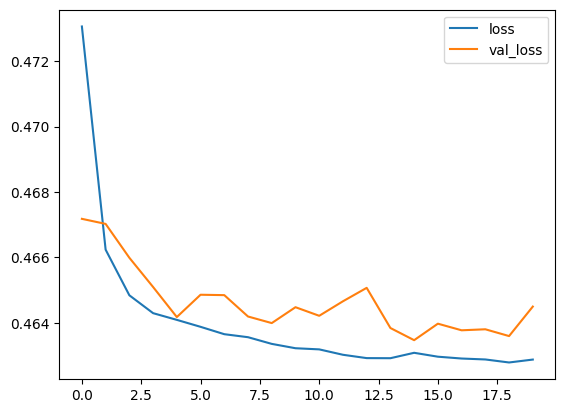

In [46]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

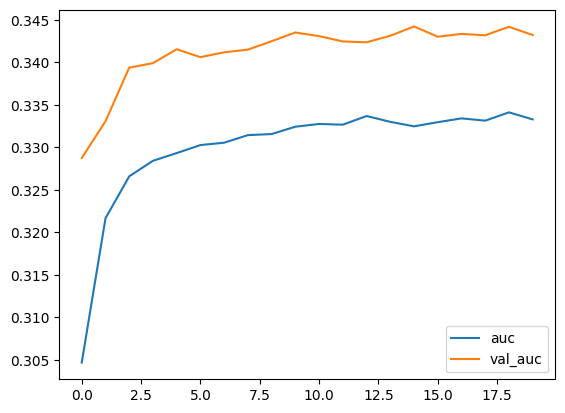

In [47]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

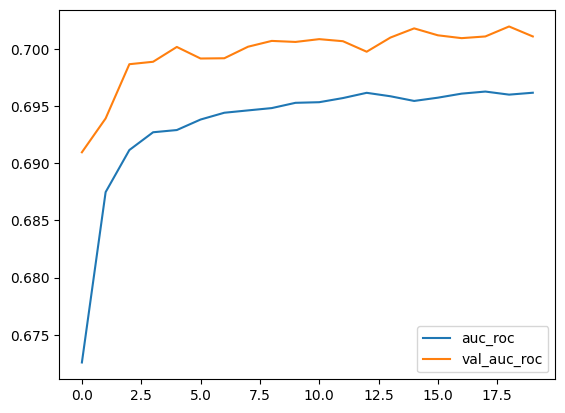

In [48]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [49]:
this_model.save(Path(setup.temp_path).joinpath('12_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [52]:
all_predictions = this_model.predict(X.drop(columns='dset'))

   81/21503 [..............................] - ETA: 41s

2024-01-11 21:14:46.736899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 42s 2ms/step


In [68]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset']], on='LoanNr_ChkDgt')
    

In [66]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.00000,0.28069
target,0.28069,1.00000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [69]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [72]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [73]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.427526
12,0.24,0.426808
10,0.20,0.426385


In [74]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [75]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [76]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.503259
0    0.496741
Name: proportion, dtype: float64

In [77]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('12_DATA_predictions.parquet'))

In [79]:
grouped = all_predictions_df.groupby(['dset'])

In [84]:
grouped.groups.keys()

dict_keys(['test', 'train', 'val'])

In [90]:
grouped = all_predictions_df.groupby(['dset'])

metrics_df = pd.concat([sg_plot.dset_metrics(g['target'], g['predict_bin'], g['predict_prob'])
                        for n, g in grouped], 
                       keys= grouped.groups.keys(), axis=1) \
    .transpose()
metrics_df.to_csv(Path(setup.temp_path).joinpath('22_REPORT_metrics_all.csv'), index=True)
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
test,0.599636,0.427307,0.299578,0.744910,0.344370,0.705389
train,0.594992,0.427526,0.299826,0.744709,0.340762,0.700236
val,0.596465,0.431633,0.303730,0.745618,0.343350,0.701180


## Embeddings
Save the hidden layer weight prior to sigmoid output, for possible later use in unsupervised GNN 

In [98]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.layers[-2].output) 

In [99]:
embed_out = embed_model.predict(X.drop(columns='dset'))

  129/21503 [..............................] - ETA: 25s

2024-01-11 21:29:28.040388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 25s 1ms/step


In [101]:
embed_out.shape

(688081, 64)

In [109]:
embed_df = pd.DataFrame(embed_out, index=X.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [110]:
embed_df.head()

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_054,emb_055,emb_056,emb_057,emb_058,emb_059,emb_060,emb_061,emb_062,emb_063
0,1000014003,-0.999884,-0.999999,-0.997035,1.000000,-0.825967,0.999999,-0.991717,0.146100,0.999987,...,-0.999988,0.999955,0.999976,-0.626606,-0.999999,-0.999121,-0.998836,-0.999999,0.957435,-0.999999
1,1000024006,-0.999652,-0.999995,-0.998412,0.999999,-0.881534,0.999999,-0.869203,0.457869,0.999940,...,-0.999999,1.000000,0.999858,0.715039,-0.999999,-0.999591,-0.996806,-1.000000,0.998142,-0.999996
2,1000034009,-0.953750,-0.999950,-0.411517,1.000000,0.593898,1.000000,-0.999999,-0.994569,0.999901,...,0.457118,0.118471,0.999864,-0.999995,-1.000000,-0.989033,-0.999992,-0.978816,-1.000000,-1.000000
3,1000084002,-0.981218,-0.999974,-0.284832,1.000000,0.661678,1.000000,-1.000000,-0.997679,0.999968,...,0.945960,-0.926991,0.999945,-0.999999,-1.000000,-0.981080,-0.999993,-0.729364,-1.000000,-1.000000
4,1000094005,-0.999508,-0.999998,-0.998118,0.999999,-0.915457,1.000000,-0.849485,0.914208,0.999911,...,-0.999999,1.000000,0.999423,0.759063,-0.999999,-0.998803,-0.998003,-1.000000,0.997810,-0.999997


In [115]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('12_DATA_embeddings.parquet'))